# AutoGenU for Jupyter

An Automatic C++ Code Generator for Nonlinear Model Predictive Control (NMPC)  

---  

## Formulation of the optimal control problem: Mobile robot

### Model description
<img src="https://raw.github.com/wiki/mayataka/CGMRES/images/fig_mobilerobot.png" width=40%>

The above figure shows the model of a mobile robot. The kinematics of the robot is given by
$$ \dot{X} = V \cos{\theta}, $$
$$ \dot{Y} = V \sin{\theta}. $$
Physical limitations of the robot are given by
$$ V_{\rm min} \leq V \leq V_{\rm max}, $$
$$ w_{\rm min} \leq \dot{\theta} \leq w_{\rm max}. $$

### Control Objective
We consider tracjectory tracking problem. We set the reference trajectory as 
$$ x_{\rm ref} (t) = \begin{bmatrix} t v_{\rm ref} \\ 0 \end{bmatrix} .$$
We also assume that there are two circular obstacles to be avoided whose center and radius are $(X_1, Y_1)$, $R_1$ and $(X_2, Y_2)$, $R_2$, respectively.

### Formulation of the optimal control problem
We define the state vector as
$$ x = \begin{bmatrix} X \\ Y \\ \theta \end{bmatrix} .$$
We assume that $V=u_1$ and $\theta = u_2$. The state equation is then given as 
$$ \dot{x} = f(t, x, u) = \begin{bmatrix} u_1 \cos{\theta} \\ u_1 \sin{\theta} \\ u_2 \end{bmatrix} $$

Next, we set the cost function 
$$ J = \varphi(t, x) + \int_{t}^{t+T} L(t, x, u) .$$
To achieve the aforementioned goal, we set the terminal cost as
$$\varphi(t,x) = \frac{1}{2} q_1 (x_1 - t v_{\rm ref})^2 + \frac{1}{2} q_2 x_2 ^2 + \frac{1}{2} q_3 x_3 ^2 $$  
and the stage cost as 
$$ L(t, x, u) = \frac{1}{2} q_1 (x_1 - t v_{\rm ref})^2 + \frac{1}{2} q_2 x_2 ^2 + \frac{1}{2} q_3 x_3 ^2 + \frac{1}{2} r_1 (u_1 \cos{x_3} - v_{\rm ref})^2 + \frac{1}{2} r_2 u_2 ^2 $$  
where $q_1, q_2, q_3$, $r_1, r_2$ are positive real constant.
From the physical limitations and the obstacles, there are 6 inequality constraints 
$$
h(x, u) = \begin{bmatrix} R_1 ^2 - (x_1 - X_1)^2 - (x_2 - Y_1)^2 \\
                          R_2 ^2 - (x_1 - X_2)^2 - (x_2 - Y_2)^2 \\
                          \end{bmatrix} \leq 0
$$
In this example, these inequality constraints are considered by the semi-smooth Fischer-Burmeister method.
In the optimization problem, the complementary conditions are imposed for inequality constraints, e.g., for $g(x, u) \in \mathbb{R}$,
$$
    g(x, u) \leq 0 ,
$$
$$
    \nu \geq 0 ,
$$
$$
    \nu g(x, u) = 0 .
$$
The semi-smooth Fischer-Burmeister method transforms these conditions into
$$
    \Phi(\nu, - g(x, u)) = 0, \;\; \Phi(a, b) = \sqrt{a^2 + b^2 + \epsilon ^2} - (a + b) .
$$
where $\epsilon > 0$ is a regularization term. 
After all, in the optimal control problem, we find the solution satisfying the following conditions
$$
    \left( \frac{\partial H}{\partial u} \right)^{\rm T} = \left( \frac{\partial L}{\partial u} \right)^{\rm T} + \left( \frac{\partial f}{\partial u} \right)^{\rm T} \lambda + \left( \frac{\partial h}{\partial u} \right)^{\rm T} \nu,
$$
$$
    \Phi(\nu_i, - h_i(x, u)) = 0 ,
$$
where $\lambda$ and $\nu$ are the Lagrange multipliers and the latter condition is imposed on elementwise.

### References 
For more details about the semi-smooth Fischer-Burmeister method in the optimal control problem, especially with the C/GMRES method, see the following references.
- [M. Huang, et. al, Nonlinear Model Predictive Control of a Diesel Engine Air Path: A Comparison of Constraint Handling and Computational Strategies, IFAC-PapersOnLine, Vol. 48, No. 23, pp. 372-379 (2015)](https://doi.org/10.1016/j.ifacol.2015.11.308)
- [M. Huang, Low Complexity Model Predictive Control of a Diesel Engine Airpath, Ph. D. diss., University of Michigan (2016)](https://deepblue.lib.umich.edu/handle/2027.42/120832)
- [S. Alamdari, S. Amin, Stochastic Model Predictive Control for Eco-Driving Assistance Systems in Electric Vehicles, Ph. D. diss., University of Luxembourg (2018)](http://orbilu.uni.lu/handle/10993/36164)
- [D. Liao-McPherson, M. Huang and I. Kolmanovsky, A Regularized and Smoothed Fischer–Burmeister Method for Quadratic Programming With Applications to Model Predictive Control, IEEE Transactions on Automatic Control, Vol. 64, No. 7, pp. 2937-2944 (2019)](https://doi.org/10.1109/TAC.2018.2872201)

### Numerical solver of NMPC
In the following example, we compute the solution of NMPC using the multiple-shooting-based C/GMRES method.

---

# Generate C++ code for optimal control problem (OCP)

## Import modules

In [24]:
import autogenu

## Set dimensions and define `AutoGenU`
- `nx`: Dimension of the state vector $x$   
- `nu`: Dimension of the control input vector $u$  
- `ocp_name`: Name of the optimal control problem (OCP). Used as the name of the directory containing the generated C++ source files.

In [25]:
nxo = 6
player = 2
nu = 4
ocp_name = 'mobilerobot_p2'
ag = autogenu.AutoGenU(ocp_name, nxo, nu, player)

## Generate t, x, and u, necessary variables to formulate of the optimal control problem
- `t`: Time parameter $t$  
- `x`: The state vector $x$  
- `u`: The control input vector $u$  

In [26]:
t = ag.define_t()
x = ag.define_x()
u = ag.define_u()
ulist = [2,2]
ag.separate_u(ulist)

[2, 2]

## Define variables used in the state equation, constraints, and cost function
- Define a scalar variable whose name is "var" as  
`var = ag.define_scalar_var('var') `

- Define scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`var_1, var_2, ..., var_n = ag.define_scalar_vars('var_1', 'var_2', ..., 'var_n')`

- Define array variables whose name is "vec" and dimension is dim_vec as  
`vec = ag.define_array_var('vec', dim_vec)`

In [27]:
# Define variables used in the state function
vx_ref = ag.define_scalar_var('vx_ref')
D = ag.define_scalar_var('D')
v_min, v_max = ag.define_scalar_vars('v_min', 'v_max')
w_min, w_max = ag.define_scalar_vars('w_min', 'w_max')
X_1, Y_1, R_1 = ag.define_scalar_vars('X_1', 'Y_1', 'R_1')
X_2, Y_2, R_2 = ag.define_scalar_vars('X_2', 'Y_2', 'R_2')
xx_ref = vx_ref * t

# Variables used in the cost function
q = ag.define_array_var('q', 5)
r = ag.define_array_var('r', 4)

## Define the state equation, constraints, the stage cost, and the terminal cost
- `f`: The state equation $ f(t, x, u)$  
- `C`: The equality constraisnts $C(t, x, u) = 0 $  
- `h`: The inequality constraisnts $h(t, x, u) \leq 0$ considered by semi-smooth Fischer-Burumeister method  
- `L`: The stage cost $L(t, x, u)$  
- `phi`: The terminal cost $\phi (t, x)$  

Note: array indices start with 0

In [28]:
# Import symbolic math from sympy. If you need more functions, import same as below.
from sympy import sin, cos, tan, exp, log, sinh, cosh, tanh, diff, sqrt

In [ ]:
# Define the state equation
fo = [u[0] * cos(x[2]), u[0] * sin(x[2]), u[1],
      u[2] * cos(x[5]), u[2] * sin(x[5]), u[3]]
    
# Define the equality constraints C(x, u) = 0
C = []

# Define the inequality constraints considered using the semi-smooth Fischer-Burmeister method
h = [R_1**2 - (x[0]-X_1)**2 - (x[1]-Y_1)**2,
     R_2**2 - (x[0]-X_2)**2 - (x[1]-Y_2)**2]

# Define the stage cost
distance_squared = (x[0] - x[3])**2 + (x[1] - x[4])**2
L = [(q[0]*(x[0]-xx_ref)**2 + q[1]*x[1]**2 + q[2]*x[2]**2) / 2 + (r[0]*(u[0]*cos(x[2])-vx_ref)**2 + r[1]*u[1]**2) / 2,
     ((q[3]*(distance_squared - D**2))**2 + q[4]*x[5]**2 )/ 2 + (r[2]*u[2]**2 + r[3]*u[3]**2) / 2]

# Define the terminal cost
phi = [(q[0]*(x[0]-xx_ref)**2 + q[1]*x[1]**2 + q[2]*x[2]**2)/2,
       ((q[3] * (distance_squared - D**2))**2 + q[4]*x[5]**2 )/ 2 ]

In [30]:
# Set functions
ag.set_functions(fo, C, h, L, phi)

## Define the control input bound constraints
The box constraints on the control input $u_{\rm min} \leq u \leq u_{\rm max}$ are treated in a special manner.
Specifically, it is transformed into $$u^2 + u_{\rm dummy}^2 - (\frac{u_{\rm max} - u_{\rm min}}{2})^2 = 0$$.  
Further, $u_{\rm dummy}$ and associated Lagrange multiplier are eliminated in Newton-type iteration efficiently in the multiple-shooting solver.  
Set such box constraints by specifying
- `uindex`: index of the constrained control input element
- `umin`: Minimum value (lower bound) of the control input element
- `umax`: Maximum value (upper bound) of the control input element
- `dummy_weight`: Weight parameter of the dummy (slack) variable

In [31]:
ag.add_control_input_bounds(uindex=0, umin=-1.0, umax=1.0, dummy_weight=0.1) 
ag.add_control_input_bounds(uindex=1, umin=-1.0, umax=1.0, dummy_weight=0.1) 
ag.add_control_input_bounds(uindex=2, umin=-1.0, umax=1.0, dummy_weight=0.1) 
ag.add_control_input_bounds(uindex=3, umin=-1.0, umax=1.0, dummy_weight=0.1) 

## Set Parameters
Set values for all parameters you defined.
- Set `value` for a scalar variable whose name is "var" as  
`ag.set_scalar_var('var', value) `

- Set `value_1`, `value_2`, ..., `value_n`, for scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`ag.set_scalar_vars(['var_1', value_1], ['var_2', value_2], ..., ['var_n', value_n])`

- Set array variables `var_1`, `var_2`, ..., `var_n` whose name is "vec" and dimension is n as  
`ag.define_array_var('vec', [var_1, var_2, ..., var_n])`

- If you define the inequality constraints using Fischer-Brumeister method `h`, then you have to define related regularization term additionaly. The dimension of the regularization term must be same as the dimension of `h`. If the dimension is `nh`, you need to set the regularization as `ag.set_FB_epsilon([eps_1, ..., eps_nh])`

In [32]:
ag.set_scalar_vars(['vx_ref', 0.4], ['X_1', 1], ['Y_1', 0.4], ['R_1', 0.5],
                   ['X_2', 3], ['Y_2', -0.4], ['R_2', 0.5],
                   ['v_min', -0.5], ['v_max', 0.5],
                   ['w_min', -0.75], ['w_max', 0.75], ['D',0.5])
ag.set_array_var('q', [10, 1, 0.01, 0.5, 0.01])
ag.set_array_var('r', [0.1, 0.1, 0.1, 0.1])

ag.set_FB_epsilon([0.01, 0.01])

## Generate C++ codes of the definition of the optimal control problem
Generate `ocp.hpp` that defines the optimal control problem (OCP).  
- `simplification`: The flag for simplification. If `True`, symbolic functions are simplified. However, if functions are too complicated, it takes too much time. Default is `False`.  
- `common_subexpression_elimination`: The flag for common subexpression elimination. If `True`, common subexpressions in fxu, phix, hx, and hu are eliminated when `ocp.hpp` is generated. Default is `False`. 

In [33]:
simplification = False
common_subexpression_elimination = True

ag.generate_ocp_definition(simplification, common_subexpression_elimination)

'ocp.hpp', the definition of the OCP, is generated at /root/autogenuN01/generated/mobilerobot_p2


---  
# Generate C++ codes of NMPC solver and numerical simulation  

## Set NLP type  
Set which NLP formulation you use. (hint: `MultipleShooting` works better for typical nonlinear problems.)
- `MultipleShooting` (recommended) : The multiple shooting based C/GMRES method with condensing of the state and the Lagragne multipliers with respect to the state equation.
- `SingleShooting` : The single shooting method, i.e., the original C/GMRES method.

In [34]:
nlp_type = autogenu.NLPType.MultipleShooting
ag.set_nlp_type(nlp_type)

## Set horizon length 

- `Tf`, `alpha`: Parameters for the length of the horizon. If $\alpha > 0$, time-varying horizon length $T(t) = T_f (1 - e^{-\alpha t})$ is used. Otherwise, $T(t)$ is fixed by $T_f$. 

In [35]:
Tf = 0.5
alpha = 1.0

ag.set_horizon_params(Tf, alpha)

## Set parameters for the C/GMRES method

- `sampling_time`: Sampling period.
- `N`: The number of the discretization grids of the horzion.  
- `finite_difference_epsilon`: Step length of a finite difference approximations of hessian-vector products in C/GMRES.   
- `zeta`: A stabilization parameter of the C/GMRES method. Basically, must be set by the reciprocal of the sampling time.  
- `kmax`: The maximam number of the iteration of the GMRES.

In [36]:
sampling_time = 0.001
N = 50
finite_difference_epsilon = 1.0e-08
zeta = 1000  
kmax = 10

ag.set_solver_params(sampling_time, N, finite_difference_epsilon, zeta, kmax)

## Set parameters for the initialization of the solution  
- `solution_initial_guess`: The initial guess of the solution of the optimal control problem (OCP) for initialization of the solution of NMPC.   
- `tolerance`: The residual tolerance of the solution of the OCP for the initialization of the solution of NMPC. The Newton iteration terminates when the optimality error is less than this velue.  
- `max_iterations`: The maxmum number of Newton iteration for the initialization of the solution of NMPC.  

In [37]:
solution_initial_guess = [0.1, 0.1, 0.1, 0.1, 0.01, 0.01]
tolerance  = 1.0e-06
max_iterations = 50

ag.set_initialization_params(solution_initial_guess, tolerance, max_iterations)

## Set parameters for numerical simulation
- `initial_time`: Initial time of the numerical simulation.  
- `initial_state`: Initial state vector of the system.  
- `simulation_length`: Simulation length.  

In [38]:
initial_time = 0  
initial_state_o = [0, 0, 0, -0.1, 0 ,0]  
simulation_length = 15

ag.set_simulation_params(initial_time, initial_state_o, simulation_length) 

## Generate main.cpp and CMakeLists.txt

In [39]:
ag.generate_main()
ag.generate_cmake()

'main.cpp', the closed-loop simulation code, is generated at /root/autogenuN01/generated/mobilerobot_p2
CMakeLists.txt are generated at /root/autogenuN01/generated/mobilerobot_p2/python


## Build and run simulation

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- `vectorize` : If `True`, the vectorization, i.e., `-march=native` compile option is enabled. This can improve speed while can cause numerical issue depending on the compiler.  
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.

In [40]:
generator = 'Auto'  
vectorize = False
remove_build_dir = False
ag.git_submodule_update()
ag.build_main(generator=generator, vectorize=vectorize, remove_build_dir=remove_build_dir)
ag.run_simulation()

Update git submodules...
Successfully updated git submodules

CMake options: -DCMAKE_BUILD_TYPE=Release -DVECTORIZE=OFF -DBUILD_MAIN=ON -DBUILD_PYTHON_INTERFACE=OFF
CMake Deprecation Warning at CMakeLists.txt:5 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.




-- Configuring done (1.4s)
-- Generating done (0.0s)
-- Build files have been written to: /root/autogenuN01/generated/mobilerobot_p2/build


[ 50%] Building CXX object CMakeFiles/mobilerobot_p2.dir/main.cpp.o
[100%] Linking CXX executable mobilerobot_p2
[100%] Built target mobilerobot_p2


Start a simulation...
End the simulation

MPC used in this simulation:
Multiple shooting CGMRES solver:
  N:    50
  kmax: 10

OCP_mobilerobot_p2:
  nx:  12
  nu:  4
  nc:  2
  nh:  2
  nuc: 6
  nub: 4

  vx_ref: 0.4
  D: 0.5
  v_min: -0.5
  v_max: 0.5
  w_min: -0.75
  w_max: 0.75
  X_1: 1
  Y_1: 0.4
  R_1: 0.5
  X_2: 3
  Y_2: -0.4
  R_2: 0.5

  q: [  10,    1, 0.01,  0.5, 0.01]
  r: [0.1, 0.1, 0.1, 0.1]

  ubound_indices: [0, 1, 2, 3]
  umin: [-1, -1, -1, -1]
  umax: [1, 1, 1, 1]
  dummy_weight: [0.1, 0.1, 0.1, 0.1]

  fb_eps: [0.01, 0.01]

Horizon: time-varying length
  Tf:    0.5
  alpha: 1
  t0:    0

Soler settings:
  max iter:                  50
  opterr tol:                1e-06
  finite diff

## Plot the simulation results

In [41]:
%matplotlib inline

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


The graph of the simlation results is generated at /root/autogenuN01/generated/mobilerobot_p2/log/mobilerobot_p2.pdf


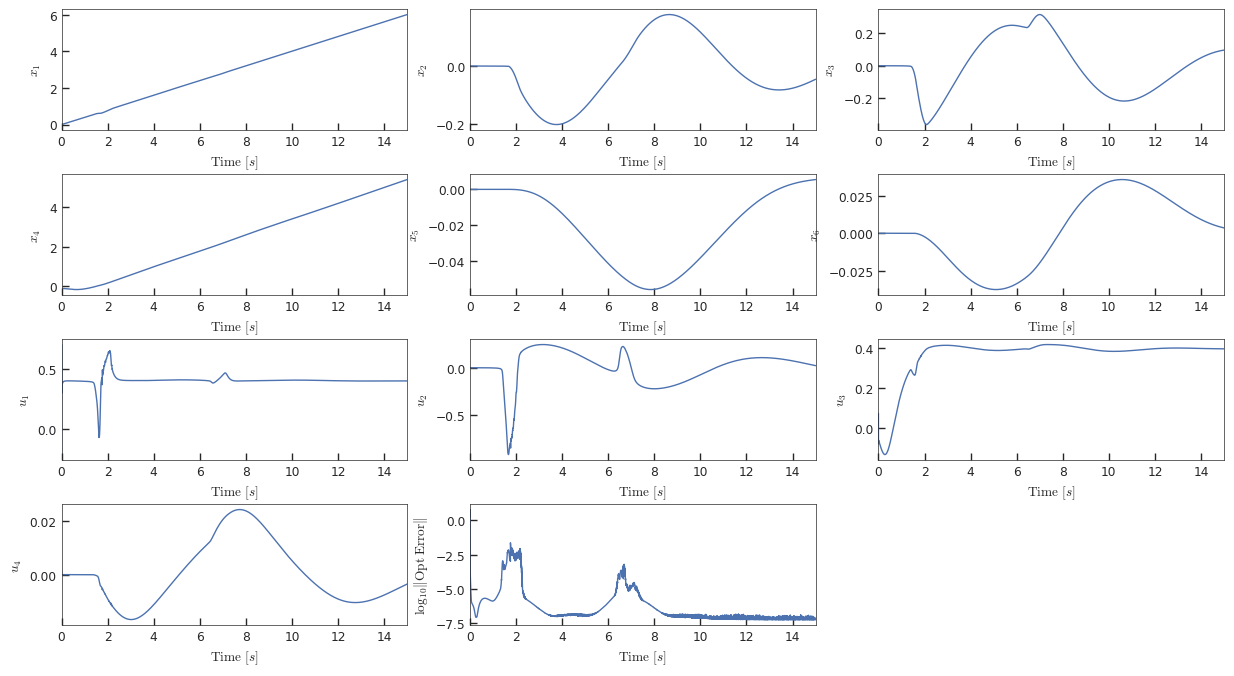

In [42]:
plotter = autogenu.Plotter(log_dir=ag.get_ocp_log_dir(), log_name=ag.get_ocp_name(), player = player)
plotter.set_scales(2,5,2)
# plotter.show()
plotter.save()

## Draw animations of the simulation results

In [43]:
# vx_ref = 0.4
# X1, Y1, R1 = 1, 0.25, 0.5
# X2, Y2, R2 = 2, -0.25, 0.5

# anim = autogenu.MobileRobot(ag.get_ocp_log_dir(), ag.get_ocp_name(), vx_ref, X1, Y1, R1, X2, Y2, R2)
# anim.set_skip_frames(10)
# anim.generate_animation()

## Build Python interface

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- `vectorize` : If `True`, the vectorization, i.e., `-march=native` compile option is enabled. This can improve speed while can cause numerical issue depending on the compiler.  
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.

In [44]:
# generator = 'Auto'  
# vectorize = False
# remove_build_dir = False
# ag.generate_python_bindings()
# ag.git_submodule_update()
# ag.build_python_interface(generator=generator, vectorize=vectorize, remove_build_dir=remove_build_dir)

## Install Python interface

- `install_prefix` : Prefix of the install destination of the python interfaces. Default is None.
    -  If this is None (default), then it is `~/.local/lib/python3.x` (`python3.x` is your Python version). 
        - If you use Ubuntu, `~/.local/lib/python3.x` is the default Python path, and you do not need to set `PYTHONPATH` additonally.  
        - If you use MacOSX or Windows, add it to the Python PATH, as `export PYTHONPATH=$PYTHONPATH:$HOME/.local/lib/python3.x/site-packages`

The usage of Python interfaces is introduced in `examples/python` directory.

In [45]:
# ag.install_python_interface(install_prefix=None)

## Generate Documentation
The documentations for the generated code are available.  
`Doxygen` is required for the docs generation.

In [46]:
# autogenu.generate_docs()
# autogenu.open_docs(